In [33]:
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import string
import pickle
import json
import re
import os

In [34]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

In [35]:
path = 'database.csv'
data= pd.read_csv(path)

In [36]:
data.head(2)

,Название,Местоположение,Часовой пояс,Улица,Примечание,Адрес,На карте,Описание,Адрес сайта,Адрес электронной почты,...,Types[],Start,ID места ЕИПСК,ServiceName,ЕИПСК,Культура.РФ,Госкаталог,Статистика,Дата создания записи,Дата последнего обновления записи
0,Аксёновская сельская библиотека-филиал № 4,Галичский район,Europe/Moscow,"д. Аксёново, 24",NaN,NaN,"{""coordinates"":[42.50301500000001,58.309780999...","<p style=""text-align:left""><span>Библиотека ос...",NaN,biblioteka-gorkogo.galich@yandex.ru,...,NaN,NaN,25431,"[{""serviceName"":""Культура.рф""}]",NaN,NaN,NaN,NaN,2016-10-20T07:48:12Z,2016-10-24T14:07:12Z
1,Мелёшинская сельская библиотека-филиал № 15,Галичский район,Europe/Moscow,"д. Мелёшино, ул. Центральная, 16",NaN,NaN,"{""coordinates"":[42.54122,58.438008],""type"":""Po...","<p style=""text-align:left""><span> Библиотека о...",NaN,biblioteka-gorkogo.galich@yandex.ru,...,NaN,NaN,25427,"[{""serviceName"":""Культура.рф""},{""serviceName"":...",NaN,NaN,NaN,NaN,2016-10-20T06:05:30Z,2016-10-24T13:57:48Z


In [4]:
data['lon'] = [json.loads(i)['coordinates'][0] for i in data['На карте']]
data['lat'] = [json.loads(i)['coordinates'][1] for i in data['На карте']]

# Принадлежность

In [15]:
import matplotlib.pyplot as plt

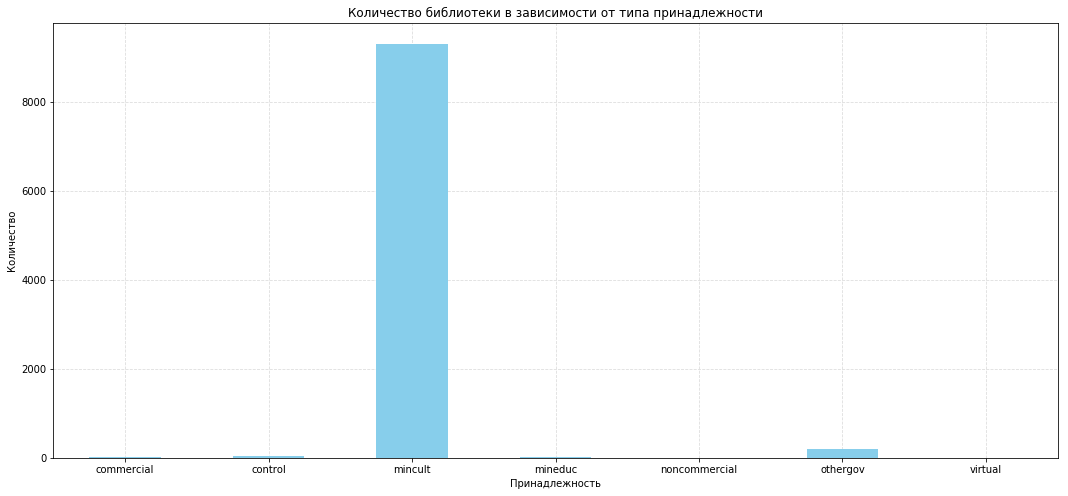

In [16]:
fig = plt.figure(figsize = (18, 8))
ax = fig.gca()

data.groupby('Принадлежность').size().plot.bar(rot=0, color='skyblue', ax=ax)
plt.xlabel('Принадлежность')
plt.ylabel('Количество')
plt.title('Количество библиотеки в зависимости от типа принадлежности')
ax.set_axisbelow(True)
ax.yaxis.grid(color='gainsboro', linestyle='dashed')
ax.xaxis.grid(color='gainsboro', linestyle='dashed')


# СТАТИСТИКА

In [ ]:
path = "region_stat_45k.json/"

res = []
indexs = []

for i in range(1, 6):
    path2 = path + str(i) + '.json' 
    
    with open(path2) as json_file:
        stat = json.load(json_file)
        
        for line in stat:
            x = line['data']['source']['longitude']
            y = line['data']['source']['longitude']

            var1 = data[(data['lon'] == x) & (data['lon'] == y)]
            var2 = data[(data['lon'] == y) & (data['lon'] == x)]

            if not var1.empty:
                res.append(var1.index)
                indexs.append(line)
            elif not var2.empty:
                res.append(var2.index)
                indexs.append(line)
            

In [30]:
len(res), len(indexs)

(114, 114)

## JSON Библиотеки

In [ ]:
path = 'data-26-structure-2.json'

In [ ]:
with open(path) as json_file:
    libr = json.load(json_file)

## Заполненность

In [38]:
def how_full(data, column):
    rcount = data[column].shape[0]
    not_empty = data[column].count()
    return (not_empty / rcount)*  100

d = {'filed': [], 'value': []}

for column in data.columns:
    d['value'].append(how_full(data, column))
    d['filed'].append(column)

In [39]:
fullness = pd.DataFrame(d)
path = 'overall/{}.tsv'
fullness.to_csv(path.format('occupancy'), sep=';', index=False)

In [40]:
np.mean(fullness.value)

59.01102354590727

# Топ нграмм

In [20]:
from nltk.util import ngrams 
import pymorphy2
import sklearn

morph = pymorphy2.MorphAnalyzer()

In [21]:
with open('decript_clean.txt', 'r', encoding='utf-8') as f:
    texts = f.read()
    texts = texts.split('\n')

In [22]:
def text_cleaning(text):
    text = re.sub('<.*?>|\xad','',text)
    text = re.sub("[" + string.punctuation + "]", " ", text)
    text = re.sub('\s+', ' ', text).strip()
    return text.lower()

def word_tok(text):
    text = text_cleaning(text)
#     text = [morph.parse(word)[0].normal_form for word in text.split()]
    return text.split()

In [23]:
def top_ngrams(text, num_n, top, all_=False):
    grams = ngrams(text, num_n)
    gram_freq = Counter(grams)
    if all_: return gram_freq
    return gram_freq.most_common(top)

In [24]:
all_descrip2 = ' '.join(texts)
all_descrip2 = text_cleaning(all_descrip2)
words_desc2 = word_tok(all_descrip2)

In [ ]:
bigrams2 = top_ngrams(words_desc2, 2, 50)
trigrams2 = top_ngrams(words_desc2, 3, 50)

In [ ]:
freqs = []

for index in range(50):
    bigr = bigrams2[index]
    trigr = trigrams2[index]
    
    for part in [bigrams2, trigrams2]:
        if '–' not in part[index][0]:
            freqs.append(part[index])
#         freqs[part[index][0]] = part[index][1]

In [ ]:
freqs = sorted(freqs, key=lambda x: x[1], reverse=True)
freqs = freqs[:55]
freqs_values = [i[1] for i in freqs]

In [ ]:
freqs_values = sklearn.preprocessing.scale(freqs_values) + 3
freqs_values = np.round(freqs_values)

In [ ]:
with open('overall/bigrams_trigrams.txt', 'w', encoding='utf-8') as f:
    for index in range(55):
        for _ in range(int(freqs_values[index])):
            f.write('_'.join(freqs[index][0]) + ',')

## ФОРМИРОВАНИЕ ПРЕДСТАВЛЕНИЙ ДЛЯ БАЗЫ

In [41]:
library_id = data['Название'].tolist()

## GAINED DATA

#### Открытие

In [42]:
def open_file(name):
    if name.endswith('pickle'):
        with open(name, 'rb') as f:
            data = pickle.load(f)
    elif name.endswith('txt'):
        with open(name, 'r', encoding='utf-8') as f:
            data = f.read()
            data = data.split('\n')
    elif name.endswith('csv'):
        data = pd.read_csv(name, sep=';')
    elif name.endswith('tsv'):
        data = pd.read_csv(name, sep='\t')
    return data

In [43]:
def convert_data(data, type_='date'):
    data2 = []
    for item in data:
        if item != '':
            if type_ == 'date':
                item = int(re.findall('[0-9]{4}', item)[0])
            elif type_ == 'izba':
                item = 'True'
            elif type_ == 'fond':
                item = int(item.split(';')[0])
        else: item = None
        data2.append(item)
    return data2

In [44]:
nrows, ncols = data.shape

In [45]:
LIBRINFO = {'library_id': list(range(nrows))}

In [46]:
path = 'open_dates_new.txt'
open_dates = open_file(path)
LIBRINFO['open_year'] = convert_data(open_dates)

#### FONDS

In [47]:
path = 'fond_numbers.txt'
fond = open_file(path)
LIBRINFO['fond_numbers'] = convert_data(fond, type_='fond')

#### Изба-читальня 


In [33]:
path = 'izba.txt'
izba = open_file(path)
LIBRINFO['izba'] = convert_data(izba, type_='izba')

#### Читатели

In [64]:
STR_NUM = {'полтора': 1.5, 'два': 2,
           'три': 3, 'четыре': 4,
           'пять': 5, 'шесть': 6,
           'семь': 7, 'восемь': 8,
           'девять': 9, 'десять': 10,}


def str_to_num(x):
    global STR_NUM
    p = morph.parse(x)[0]
    return STR_NUM.get(p.normal_form)


def convert_str_to_int(v):
    if ',' in v and '_' not in v: v += '_1000' 
    v = re.sub(',', '.', v)
    v = re.sub(' ', '', v)
    if '_' in v:        
        number, z = v.split('_')
        z = int(z)
        if '.' in number:
            n = float(number)
            v = n * z
        elif number.isalpha():
            n = str_to_num(number)
            v = n * z
        else:
            n = int(number)
            if n/z > 1: v = n
            else: v = n * z
    elif '.' in v: v = float(v)    
    else: v = int(v)        
    return v


def value_convert(values, type_='n_readers'):
    res = []
    for value in values:
        if '-' in value:
            for val in value.split('-'):
                val = convert_str_to_int(val)
                if type_ == 'n_readers' and val < 50: continue
                else: res.append(val)
        else: 
            val = convert_str_to_int(value)
            if type_ == 'n_readers' and val < 50: continue
            else: res.append(val)
    if res:
        if type_ == 'n_readers': return min(res)
        return max(res)
    return None
    

In [66]:
def pickle_data(nrows, data, type_='n_readers'):
    data2 = []
    for row in range(nrows):
        value = data.get(row)
        if value: 
            if type_ == 'area_surface': value = sum(value)
            else: value = value_convert(value, type_=type_)
        data2.append(value)
    return data2

In [67]:
path = 'new/n_readers.pickle'
readers = open_file(path)
LIBRINFO['n_readers'] = pickle_data(nrows, readers)

### Посещения

In [68]:
path = 'new/number_visits.tsv'
nvis = open_file(path)
# LIBRINFO['n_readers'] = pickle_data(nrows, readers)

### в n году/ за n год

In [69]:
with_year = nvis['year'].dropna().index
with_year = set(with_year)

In [70]:
in_year = nvis[nvis['prep'].isin(["в", "за"])]['n_days'].index
in_year = set(in_year)
in_year_index = with_year & in_year

In [71]:
for index in in_year_index:
    nvis['n_days'].loc[index] = 365

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### на n год

In [72]:
by_year = nvis[nvis['prep'] == "на"].index
by_year = set(by_year)
by_year_index = by_year & with_year

In [73]:
for index in by_year_index:
    date = LIBRINFO['open_year'][index]
    if date:
        duration = nvis['year'].loc[index] - date 
        nvis['n_days'].loc[index] = 365 * duration

### с n года

In [74]:
from_year = nvis[nvis['prep'] == "с"].index
from_year = set(from_year)
from_year_index = from_year & with_year

In [75]:
for index in from_year_index:
    res = 2019 - nvis['year'].loc[index]
    nvis['n_days'].loc[index] = 365 * res

##### Посещения в месяц

In [76]:
filled_rows = nvis.dropna(subset=['n_visits']).index

In [77]:
for index in filled_rows:
    value = nvis['n_visits'][index]
    value = convert_str_to_int(value)
    if LIBRINFO['n_readers'][index] == value and value > 1000:
        value = None
    nvis['n_visits'].loc[index] = value

In [78]:
nvis['n_days'] = np.round(nvis['n_days'] / 30)

In [79]:
vis_per_month = []

for index in range(nrows):
    nv = nvis['n_visits'][index]
    nd = nvis['n_days'][index]
    value = None
    if nv and nd: value = np.round(nv / nd)
    vis_per_month.append(value)
    
LIBRINFO['visits_month'] = vis_per_month

## Зона обслуживания

In [80]:
path = 'new/servise_area.pickle'
servise_area = open_file(path)
LIBRINFO['servise_area'] = pickle_data(nrows, servise_area)

## Площади библиотек

In [81]:
path = 'new/area_surface.pickle'
area_surface = open_file(path)
LIBRINFO['area_surface'] = pickle_data(nrows, area_surface, type_='area_surface')

## Площади фондов

In [82]:
path = 'new/book_storage.pickle'
book_storage = open_file(path)
LIBRINFO['book_storage'] = pickle_data(nrows, book_storage, type_='area_surface')

## Площади читальных залов

In [83]:
path = 'new/public_area.pickle'
public_area = open_file(path)
LIBRINFO['public_area'] = pickle_data(nrows, public_area, type_='area_surface')

### Жанры

In [33]:
path = 'new/book_geners.pickle'
geners = open_file(path)

In [34]:
needed = ['газета', 'география', 'аудиовизуальный материал', 'другой иностранный язык',
          'детский', 'естествознание', 'журнал', 'кассета',
          'краеведение', 'крымскотатарский язык', 'литературоведение',
          'медицинский литература', 'методический', 'мусульманский',
          'отраслевой', 'периодика','подросток','редкий книга', 'чувашский язык',
          'русский язык', 'сельский хозяйство', 'спорт', 'справочный литература', 'татарский язык', 'техника',
          'художественный']

In [37]:
renamed = {'естественнонаучный': 'естествознание',
           'естественнонаучный литература': 'естествознание', 
           'естествознание': 'естествознание',
           'краеведение': 'краеведение',
           'краеведческий': 'краеведение', 
           'краеведческий издание': 'краеведение',
           'краеведческий литература': 'краеведение',
           'отраслевой': 'отраслевой', 'отраслевой и': 'отраслевой',
           'отраслевой литература': 'отраслевой', 
           'художественный': 'художественный',
           'художественный литература': 'художественный',
           'это художественный литература': 'художественный'}

In [38]:
fond = {}
extradition = {}
# res = {key:[None]*9546 for key in needed}
genre_freq = {key:0 for key in needed}
libr_genre = []

for index in range(nrows): #genres:
    inf = geners.get(index)
    lgenres = []
    if inf:
        for name in inf: #geners[index]:
            n = convert_str_to_int(geners[index][name])
            if 'фонд' in name:
                fond[index] = n
            elif 'выдача' in name:
                extradition[index] = n
            if 'детский' in name:1
#                 res['детский'].[index] = n
            else:
                gn = renamed.get(name)
                if gn: name = gn
                if name in needed: 
                    genre_freq[name] += 1
                    lgenres.append(name)
    if not lgenres: lgenres = None
    libr_genre.append(lgenres)

In [39]:
LIBRINFO['litr_genres'] = libr_genre

In [40]:
for index in fond:
    LIBRINFO['fond_numbers'][index] = fond[index]

In [348]:
with open('overall/genre_freq.csv', 'w', encoding='utf-8') as f:
    for i in genre_freq:
        f.write('{};{}\n'.format(i, genre_freq[i]))

## OVERALL

In [53]:
LIBR = pd.DataFrame(LIBRINFO)

## Кто какую информацию сообшал

In [85]:
path = 'new/libr_region_name.txt'

In [86]:
region_names = open_file(path)

In [87]:
LIBR['region'] = region_names

In [88]:
LIBR.head(2)

,library_id,open_year,fond_numbers,izba,n_readers,visits_month,servise_area,area_surface,book_storage,public_area,region
0,0,1973.0,3306.0,None,91.0,NaN,100.0,NaN,NaN,NaN,костромская
1,1,1945.0,5787.0,None,NaN,NaN,190.0,NaN,NaN,NaN,костромская


In [89]:
stat_counts = LIBR.groupby('region').count()

In [90]:
stat_counts.head()

,library_id,open_year,fond_numbers,izba,n_readers,visits_month,servise_area,area_surface,book_storage,public_area
region,,,,,,,,,,
адыгея,20,12,14,0,13,8,0,0,0,0
алтай,5,1,3,0,2,0,0,0,0,0
алтайский,63,24,45,12,40,3,0,1,0,0
амурская,50,27,35,6,24,13,0,1,0,0
архангельская,88,49,60,12,40,5,0,7,0,0


In [91]:
stat_counts[stat_counts['fond_numbers'] == 0]

,library_id,open_year,fond_numbers,izba,n_readers,visits_month,servise_area,area_surface,book_storage,public_area
region,,,,,,,,,,
ингушетия,2,0,0,0,0,0,0,0,0,0
карачаево-черкесская,2,1,0,0,0,1,0,0,0,0
якутия,4,1,0,0,1,0,0,0,0,0


In [61]:
field_nregions = {'indicator': [], 'value': []}

for column in stat_counts.columns:
    df = stat_counts[stat_counts[column] > 0]
    field_nregions['indicator'].append(column)
    field_nregions['value'].append(df.shape[0])
    

In [67]:
region_counts_fields = pd.DataFrame(field_nregions)
region_counts_fields['per'] = (region_counts_fields['value']/85)*100
region_counts_fields.sort_values('value', ascending=False)

,indicator,value,per
0,library_id,84,98.823529
1,open_year,83,97.647059
2,fond_numbers,81,95.294118
3,n_readers,81,95.294118
4,visits_month,75,88.235294
6,area_surface,66,77.647059
5,servise_area,18,21.176471
8,public_area,9,10.588235
7,book_storage,7,8.235294


##### Лидеры по представлению информации

In [92]:
nlibr_count = Counter(LIBR['region'])

In [95]:
nlibr = [nlibr_count[i] for i in stat_counts.index]

In [99]:
max_values = {'field': [], 'max': []}
for column in stat_counts.columns:
    stat_counts[column] = stat_counts[column]/nlibr
    index = stat_counts[column].argmax()
    reg = stat_counts.index[index]
    max_values['field'].append(column)
    max_values['max'].append(reg)

In [100]:
pd.DataFrame(max_values)

,field,max
0,library_id,адыгея
1,open_year,ненецкий
2,fond_numbers,калмыкия
3,izba,белгородская
4,n_readers,липецкая
5,visits_month,карачаево-черкесская
6,servise_area,пензенская
7,area_surface,ненецкий
8,book_storage,московская
9,public_area,московская


# Кто не указал вообще никакой информации

In [105]:
filling_activity = stat_counts.sum(axis=1).reset_index()

In [106]:
filling_activity.head()

,region,0
0,адыгея,3.350000
1,алтай,2.200000
2,алтайский,2.984127
3,амурская,3.120000
4,архангельская,2.988636


In [108]:
filling_activity.to_csv('region_field_activity.csv', sep=';')

## Типы библиотек в зависимости от размера фонда

In [54]:
def libry_fond_type(fond):
    value = None
    if isinstance(fond, float):
        if fond < 50000: value = 'малые'
        elif fond >= 50000 and fond < 200000: value = 'небольшие'
        elif fond >= 200000 and fond < 1000000: value = 'средние'
        elif fond >= 1000000 and fond < 5000000: value = 'крупные'
        elif fond >= 5000000: value = 'крупнейшие'
    return value

In [55]:
LIBR['libr_fond_type'] = LIBR['fond_numbers'].apply(libry_fond_type)

In [56]:
d = defaultdict(int)

for index in LIBR.index:
    fond = LIBR['libr_fond_type'][index]
    if fond:
        if 'сельская' in data['Название'][index].lower():
            d[fond] += 1
    

In [48]:
with open('Типы библиотек/selo.txt', 'r') as f:
    selo = f.read()
    selo = selo.split(',')
    selo = [int(i) for i in selo]

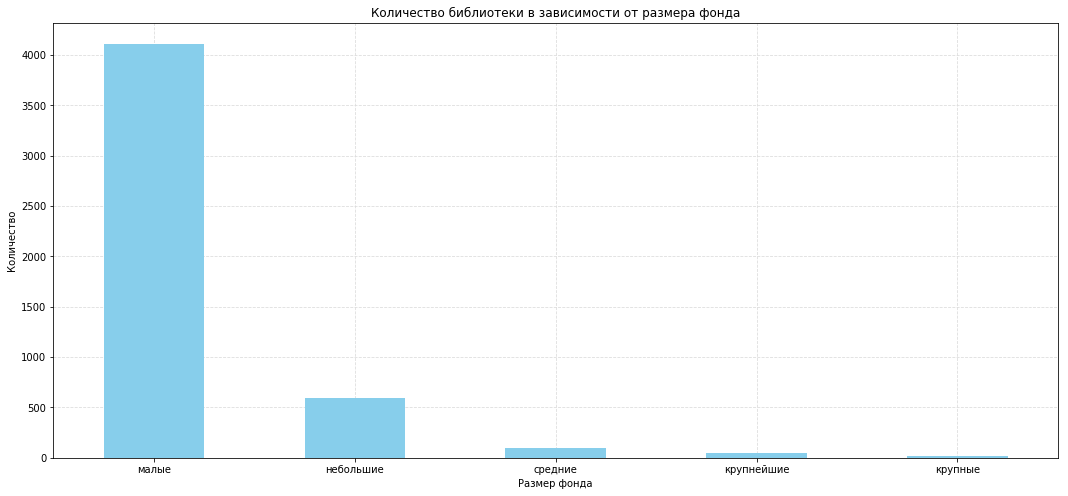

In [48]:
fig = plt.figure(figsize = (18, 8))
ax = fig.gca()
df.plot.bar(rot=0, color='skyblue', ax=ax)
plt.xlabel('Размер фонда')
plt.ylabel('Количество')
plt.title('Количество библиотеки в зависимости от размера фонда')
ax.set_axisbelow(True)
ax.yaxis.grid(color='gainsboro', linestyle='dashed')
ax.xaxis.grid(color='gainsboro', linestyle='dashed')
plt.savefig(plot_path + 'libr_fond_types' + ".svg", format='svg', dpi=1200)

## Заполненность 

In [343]:
libr_stat_count = LIBR.count().reset_index()
libr_stat_count['persent'] = np.round((libr_stat_count[0]/nrows) * 100, 3)

In [344]:
libr_stat_count

,index,0,persent
0,library_id,9546,100.000
1,open_year,3888,40.729
2,fond_numbers,4916,51.498
3,izba,850,8.904
4,n_readers,3722,38.990
5,visits_month,1019,10.675
6,servise_area,63,0.660
7,area_surface,724,7.584
8,public_area,28,0.293
9,book_storage,15,0.157


# Называют ли новые библиотеки в честь спонсоров и меценатов

In [30]:
import pickle

with open('libr_pers_prof.pickle', 'rb') as f:
     libr_pers_prof = pickle.load(f)

In [32]:
opend_prof = {'date': [], 'prof': [], 'name': []}

for libr_index in libr_pers_prof:
    openDate = LIBRINFO['open_year'][libr_index]
    if openDate and openDate > 1990:
        for prof in libr_pers_prof[libr_index][0]:
            opend_prof['date'].append(openDate)
            opend_prof['prof'].append(prof)
            opend_prof['name'].append(libr_pers_prof[libr_index][1])

In [33]:
pd.DataFrame(opend_prof)

,date,prof,name
0,2007,literature,"адрианов, ю., а."
1,2010,literature,"грин, а., с."
2,1994,education,"ерошенко, в., я."
3,1991,education,"зайцева, н., а."
4,2016,journalism,"карамзина, н., м."
5,1992,science,"петряева, е., д."
6,2003,science,"пирожников, г., а."
7,1996,literature,полевой
8,2016,literature,"пришвин, м., м."
9,2014,film and theatre,"пушкин, а., с."


# Зависимость типа от фонда

In [66]:
from scipy.stats import chi2_contingency

In [48]:
type_index_path = 'Типы библиотек/types_libr.csv'
type_index = pd.read_csv(type_index_path, sep=';')
type_index['len'] = type_index.inds.apply(len)
type_index = type_index.sort_values('len', ascending=False)

In [50]:
area_type = type_index[type_index['type'] == 'area']

In [63]:
vec = [None] * LIBR.shape[0]

for index in area_type.index: 
    typ = area_type.loc[index]['name']
    for ind in area_type.loc[index]['inds'].split(','):
        vec[int(ind)] = typ
    

In [64]:
LIBR['typ'] = vec

In [ ]:
chi2, p, dof, expected = chi2_contingency(observed)

In [71]:
l2 = LIBR.dropna(subset=['typ', 'libr_fond_type'])

In [75]:
l2[['libr_fond_type', 'typ']].groupby(['libr_fond_type', 'typ']).size().unstack()

typ,городской,земский,зональный,межмуниципальный,межпоселенческий,муниципальный,областной,поселенческий,поселковый,районный,региональный,республиканский,сельский
libr_fond_type,,,,,,,,,,,,,
крупнейшие,3.0,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,13.0
крупные,3.0,NaN,NaN,NaN,1.0,NaN,5.0,NaN,NaN,3.0,NaN,NaN,1.0
малые,226.0,1.0,NaN,NaN,58.0,23.0,3.0,86.0,32.0,127.0,NaN,2.0,1489.0
небольшие,99.0,NaN,1.0,2.0,50.0,5.0,19.0,3.0,1.0,50.0,NaN,5.0,27.0
средние,11.0,NaN,NaN,NaN,12.0,2.0,5.0,NaN,NaN,13.0,NaN,2.0,3.0
